# Computer Vision Project : Enhancing Nucleus Segmentation and 3D Reconstruction Using Super-Resolution


## Group Members:
### Rita Sulaiman – Student ID: 2210765051
### Zeynep Yıldız – Student ID: 2210765033
### Zharasbek Bimagambetov – Student ID: 2210356185


### Imports

In [39]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


### Preprocessing and Image Display

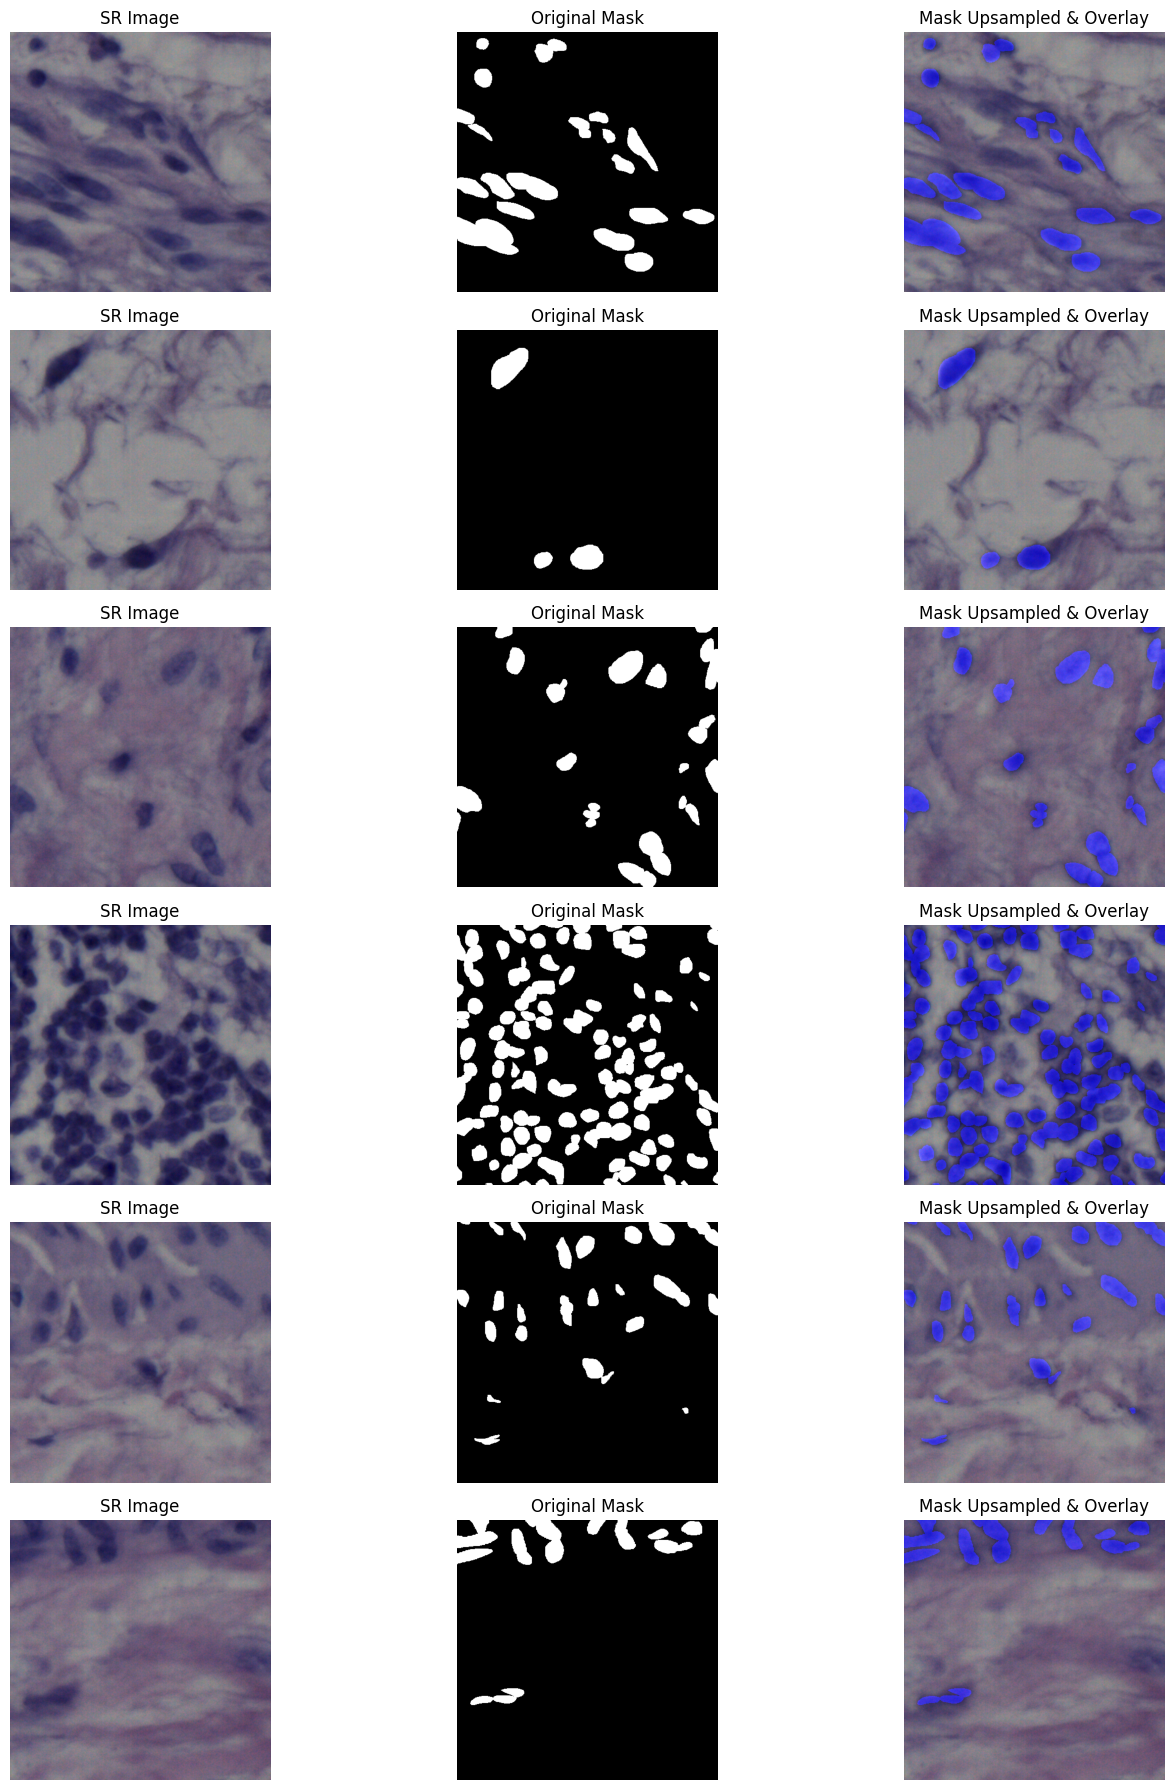

Preprocessing complete
X shape: (12, 512, 512, 3)
Y shape: (12, 512, 512, 1)


In [40]:
# ================================
#  LOAD, DISPLAY, AND PREPROCESS
# ================================

image_files = sorted(os.listdir(IMAGE_DIR))
mask_files  = sorted(os.listdir(MASK_DIR))

X = []  # Preprocessed images
Y = []  # Preprocessed masks

num_samples = min(6, len(image_files))  # For visualization
fig, axes  = plt.subplots(num_samples, 3, figsize=(15, num_samples * 3))

for i in range(len(image_files)):
    img_path  = os.path.join(IMAGE_DIR, image_files[i])
    mask_path = os.path.join(MASK_DIR,  mask_files[i])

    # Load SR image and raw mask
    image_bgr  = cv2.imread(img_path, cv2.IMREAD_COLOR)
    mask_gray  = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Convert to RGB
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # --- Display-only (first few samples) ---
    if i < num_samples:
        # 1) Upsample the mask to SR image size
        full_h, full_w = image_rgb.shape[:2]
        mask_full = cv2.resize(
            mask_gray,
            (full_w, full_h),
            interpolation=cv2.INTER_NEAREST
        )

        # 2) Build color overlay (red channel)
        color_mask = np.zeros_like(image_rgb)
        color_mask[:, :, 2] = mask_full  # assign into red channel

        # 3) Blend
        overlay = cv2.addWeighted(image_rgb, 1.0, color_mask, 0.5, 0)

        # Plot
        axes[i, 0].imshow(image_rgb)
        axes[i, 0].set_title("SR Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(mask_gray, cmap="gray")
        axes[i, 1].set_title("Original Mask")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(overlay)
        axes[i, 2].set_title("Mask Upsampled & Overlay")
        axes[i, 2].axis("off")

    # --- Preprocess for model ---
    image = preprocess_image(image_rgb, TARGET_SIZE)
    mask  = preprocess_mask(mask_gray, TARGET_SIZE)

    X.append(image)
    Y.append(mask)

plt.tight_layout()
plt.show()

# Convert lists to arrays
X = np.array(X)
Y = np.array(Y)

print("Preprocessing complete")
print("X shape:", X.shape)
print("Y shape:", Y.shape)


### Segmantation

Prepare PyTorch Dataset & DataLoader

In [41]:
import random
from torch.utils.data import Dataset

class SRCropDataset(Dataset):
    def __init__(self, img_dir, mask_dir, crop_size=512, transform=None):
        self.img_paths  = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir)])
        self.mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])
        self.crop_size  = crop_size
        self.transform  = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path  = self.img_paths[idx]
        mask_path = self.mask_paths[idx]

        # 1) Load
        img  = cv2.imread(img_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # 2) Fail early if either is None
        if img is None:
            raise FileNotFoundError(f"Could not read image: {img_path}")
        if mask is None:
            raise FileNotFoundError(f"Could not read mask:  {mask_path}")

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        H, W = img.shape[:2]
        ch   = self.crop_size

        # 3) Guard random crop on small images
        if H < ch or W < ch:
            img  = cv2.resize(img,  (ch, ch), interpolation=cv2.INTER_AREA)
            mask = cv2.resize(mask,(ch, ch), interpolation=cv2.INTER_NEAREST)
            top = left = 0
        else:
            top  = random.randint(0, H - ch)
            left = random.randint(0, W - ch)

        img_crop = img [top:top+ch, left:left+ch]
        msk_crop = mask[top:top+ch, left:left+ch]

        # 4) Normalize & to tensor
        img_crop = img_crop.astype(np.float32)/255.0
        msk_crop = (msk_crop > 127).astype(np.float32)
        img_t = torch.from_numpy(img_crop).permute(2,0,1)
        msk_t = torch.from_numpy(msk_crop).unsqueeze(0)

        return img_t, msk_t

In [42]:
from torch.utils.data import DataLoader

# — now use random-crop training
train_ds = SRCropDataset(
    img_dir="sr_images",
    mask_dir="mask binary",
    crop_size=512
)
train_loader = DataLoader(
    train_ds,
    batch_size=2,       # start small to avoid OOM
    shuffle=True,
    num_workers=0,
    pin_memory=True
)
print(f"Train size: {len(train_ds)}")


Train size: 12


Split into Train/Validation & DataLoaders

Define U-Net Model

In [43]:
import torch.nn as nn
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super().__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64,128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128,256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256,512))
        self.up2 = nn.ConvTranspose2d(512,256,2,2); self.conv2 = DoubleConv(512,256)
        self.up1 = nn.ConvTranspose2d(256,128,2,2); self.conv1 = DoubleConv(256,128)
        self.up0 = nn.ConvTranspose2d(128,64,2,2);  self.conv0 = DoubleConv(128,64)
        self.outc = nn.Conv2d(64, n_classes, 1)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up2(x4); x = torch.cat([x, x3],1); x = self.conv2(x)
        x = self.up1(x); x = torch.cat([x, x2],1); x = self.conv1(x)
        x = self.up0(x); x = torch.cat([x, x1],1); x = self.conv0(x)
        return self.outc(x)

Define Loss, Metrics, and Optimizer

In [44]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

def dice_coeff(preds, targets, eps=1e-6):
    preds_flat = preds.view(-1)
    targets_flat = targets.view(-1)
    intersection = (preds_flat * targets_flat).sum()
    return (2*intersection + eps) / (preds_flat.sum() + targets_flat.sum() + eps)

Training Loop with Validation

In [45]:
epochs = 50
history = {'train_loss':[], 'train_dice':[], 'val_loss':[], 'val_dice':[]}

for epoch in range(1, epochs+1):
    # Train
    model.train()
    train_loss = 0; train_dice = 0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, masks)
        loss.backward(); optimizer.step()
        train_loss += loss.item() * imgs.size(0)
        probs = torch.sigmoid(logits); preds = (probs>0.5).float()
        train_dice += dice_coeff(preds, masks).item() * imgs.size(0)
    train_loss /= len(train_ds)
    train_dice /= len(train_ds)

    # Validate
    model.eval()
    val_loss = 0; val_dice = 0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            logits = model(imgs)
            loss = criterion(logits, masks)
            val_loss += loss.item() * imgs.size(0)
            probs = torch.sigmoid(logits); preds = (probs>0.5).float()
            val_dice += dice_coeff(preds, masks).item() * imgs.size(0)
    val_loss /= len(val_ds)
    val_dice /= len(val_ds)

    history['train_loss'].append(train_loss)
    history['train_dice'].append(train_dice)
    history['val_loss'].append(val_loss)
    history['val_dice'].append(val_dice)

    print(f"Epoch {epoch}/{epochs}"
          f" - Train Loss: {train_loss:.4f} - Train Dice: {train_dice:.4f}"
          f" - Val Loss: {val_loss:.4f} - Val Dice: {val_dice:.4f}")


RuntimeError: stack expects each tensor to be equal size, but got [1, 0, 334] at entry 0 and [1, 0, 392] at entry 1

In [ ]:
def sliding_window_inference(sr_img, model, device,
                             tile_size=512, overlap=0.5):
    model.eval()
    H, W = sr_img.shape[:2]
    stride = int(tile_size * (1 - overlap))
    full_mask = np.zeros((H, W), np.uint8)
    count_map = np.zeros((H, W), np.uint8)

    for y in range(0, H - tile_size + 1, stride):
        for x in range(0, W - tile_size + 1, stride):
            patch = sr_img[y:y+tile_size, x:x+tile_size]
            inp = patch.astype(np.float32)/255.0
            inp = torch.from_numpy(inp).permute(2,0,1).unsqueeze(0).to(device)

            with torch.no_grad():
                logits = model(inp)
                probs  = torch.sigmoid(logits)
                pred   = (probs>0.5).cpu().numpy()[0,0].astype(np.uint8)

            full_mask[y:y+tile_size, x:x+tile_size] += pred
            count_map[y:y+tile_size, x:x+tile_size] += 1

    avg_mask = full_mask.astype(np.float32) / count_map
    return (avg_mask > 0.5).astype(np.uint8)

# Example usage:
model.load_state_dict(torch.load("unet_sr.pth"))
model.to(device)
sr_img = cv2.cvtColor(cv2.imread("sr_images/0001.png"), cv2.COLOR_BGR2RGB)
mask   = sliding_window_inference(sr_img, model, device)

plt.figure(figsize=(10,10))
plt.imshow(sr_img)
plt.imshow(mask, cmap="jet", alpha=0.4)
plt.axis("off")


Plot Loss and Dice Curves

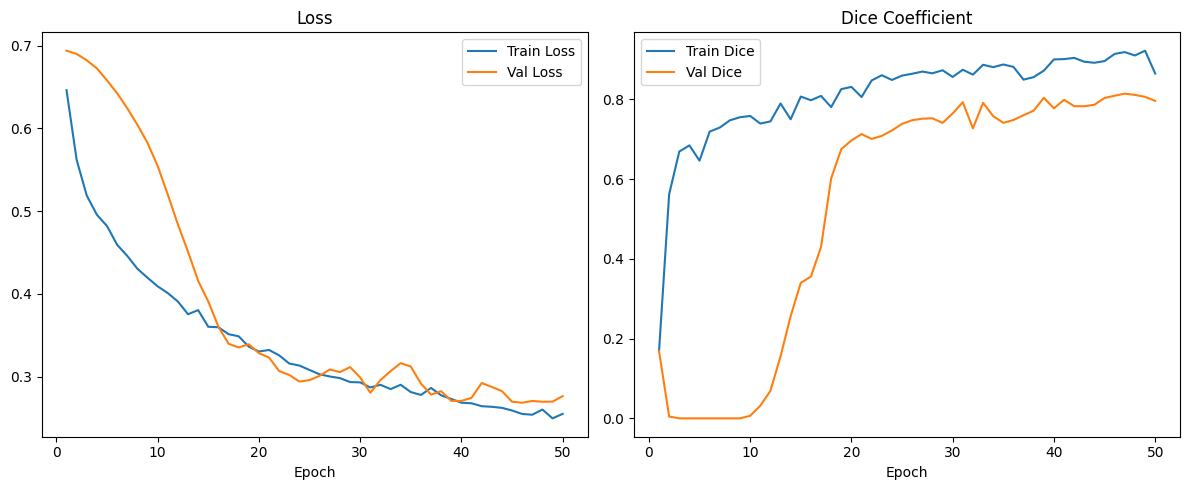

In [ ]:
epochs_range = range(1, epochs+1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, history['train_loss'], label='Train Loss')
plt.plot(epochs_range, history['val_loss'],   label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch'); plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, history['train_dice'], label='Train Dice')
plt.plot(epochs_range, history['val_dice'],   label='Val Dice')
plt.title('Dice Coefficient')
plt.xlabel('Epoch'); plt.legend()

plt.tight_layout(); plt.show()

Visualize a few predictions

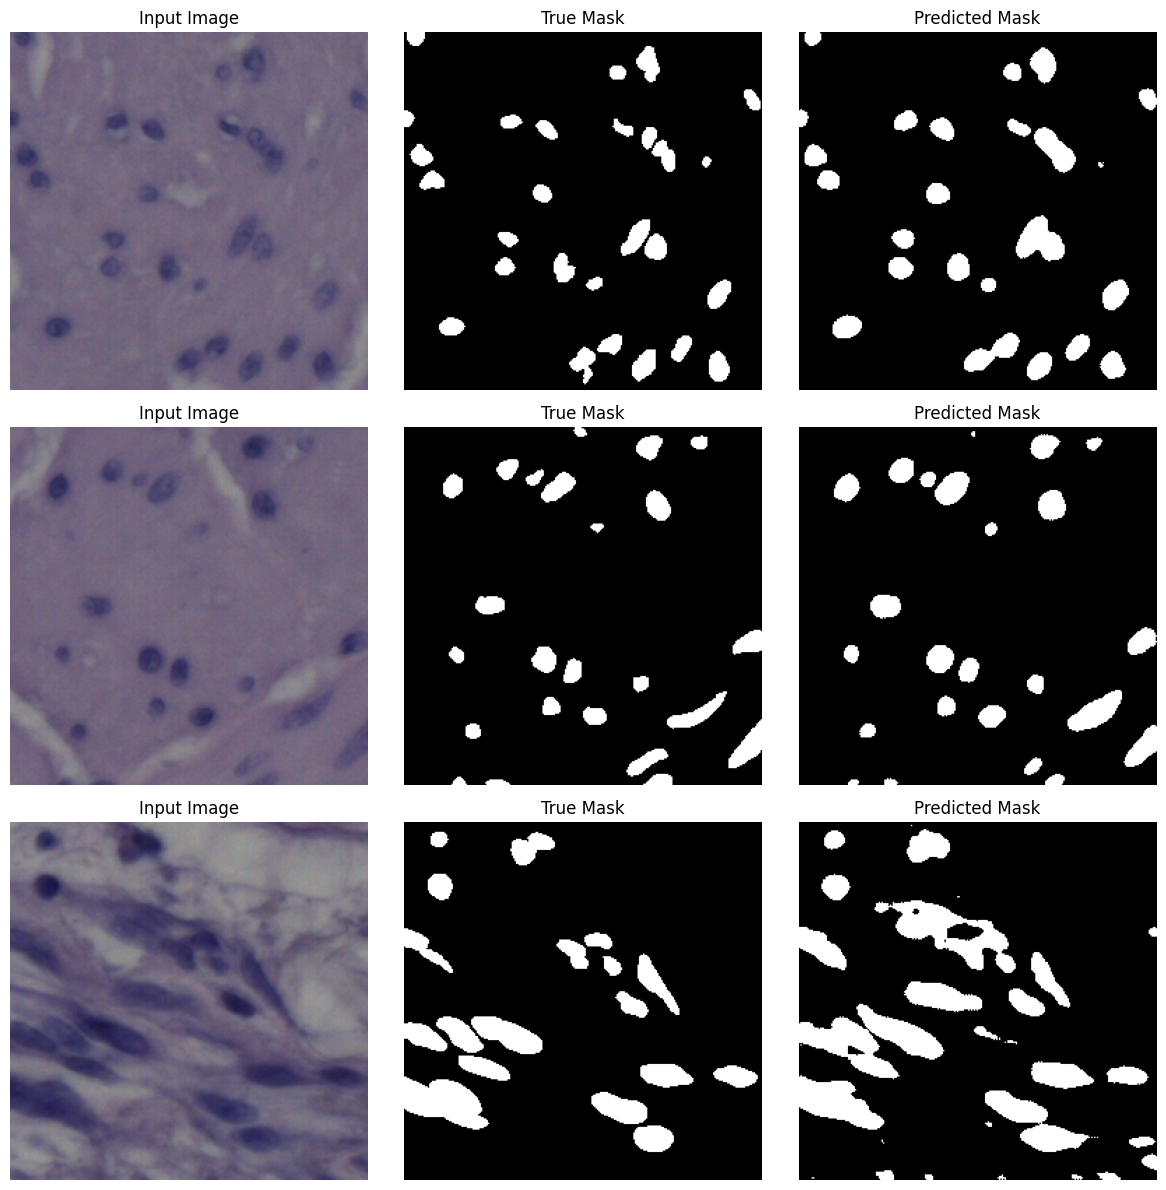

In [ ]:
model.eval()
with torch.no_grad():
    imgs, masks = next(iter(val_loader))       # grab one batch
    imgs = imgs.to(device)
    logits = model(imgs)
    probs = torch.sigmoid(logits).cpu().numpy()
    masks = masks.numpy()

# Number of examples to show
n = 3
fig, axes = plt.subplots(n, 3, figsize=(12, n*4))
for i in range(n):
    img       = imgs[i].permute(1,2,0).cpu().numpy()
    true_mask = masks[i].squeeze()
    pred_mask = (probs[i].squeeze() > 0.5).astype(float)

    axes[i,0].imshow(img)
    axes[i,0].set_title("Input Image")
    axes[i,0].axis("off")

    axes[i,1].imshow(true_mask, cmap="gray")
    axes[i,1].set_title("True Mask")
    axes[i,1].axis("off")

    axes[i,2].imshow(pred_mask, cmap="gray")
    axes[i,2].set_title("Predicted Mask")
    axes[i,2].axis("off")

plt.tight_layout()
plt.show()


Define IoU Metric

In [ ]:
def iou_coeff(preds, targets, eps=1e-6):
    """
    preds, targets: torch.Tensor of shape (B,1,H,W) with 0/1 values
    returns mean IoU over the batch.
    """
    preds_flat = preds.view(preds.size(0), -1)
    targets_flat = targets.view(targets.size(0), -1)
    intersection = (preds_flat * targets_flat).sum(1)
    union = preds_flat.sum(1) + targets_flat.sum(1) - intersection
    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()


Evaluate on Held-Out Test Set

In [ ]:
# (Here we reuse val_loader as a test set; if you have a separate test split, swap in test_loader)

model.eval()
test_loss = 0.0
test_dice = 0.0
test_iou  = 0.0
with torch.no_grad():
    for imgs, masks in val_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        logits = model(imgs)
        test_loss += criterion(logits, masks).item() * imgs.size(0)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
        test_dice += dice_coeff(preds, masks).item() * imgs.size(0)
        test_iou  += iou_coeff(preds, masks) * imgs.size(0)

n_test = len(val_ds)
print(f"Test Loss: {test_loss/n_test:.4f}")
print(f"Test Dice: {test_dice/n_test:.4f}")
print(f"Test  IoU: {test_iou/n_test:.4f}")


Test Loss: 0.2766
Test Dice: 0.7962
Test  IoU: 0.6830


Threshold Tuning Curve

In [ ]:
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
results = []

model.eval()
with torch.no_grad():
    # collect all logits and masks
    all_logits, all_masks = [], []
    for imgs, masks in val_loader:
        logits = model(imgs.to(device))
        all_logits.append(logits.cpu())
        all_masks.append(masks)
    all_logits = torch.cat(all_logits)
    all_masks  = torch.cat(all_masks)

for thr in thresholds:
    preds = (torch.sigmoid(all_logits) > thr).float()
    d = dice_coeff(preds, all_masks).item()
    j = iou_coeff(preds, all_masks)
    results.append((thr, d, j))

# Display
print(" Thr | Dice   |  IoU")
print("------------------------")
for thr, d, j in results:
    print(f" {thr:.1f} | {d:.4f} | {j:.4f}")


 Thr | Dice   |  IoU
------------------------
 0.3 | 0.6773 | 0.5434
 0.4 | 0.7580 | 0.6365
 0.5 | 0.7962 | 0.6830
 0.6 | 0.8133 | 0.7031
 0.7 | 0.8134 | 0.7008


Error Analysis – Worst-Performing Samples

Worst 5 samples by Dice:
 Sample 002 – Dice: 0.7534
 Sample 001 – Dice: 0.8314
 Sample 000 – Dice: 0.8461


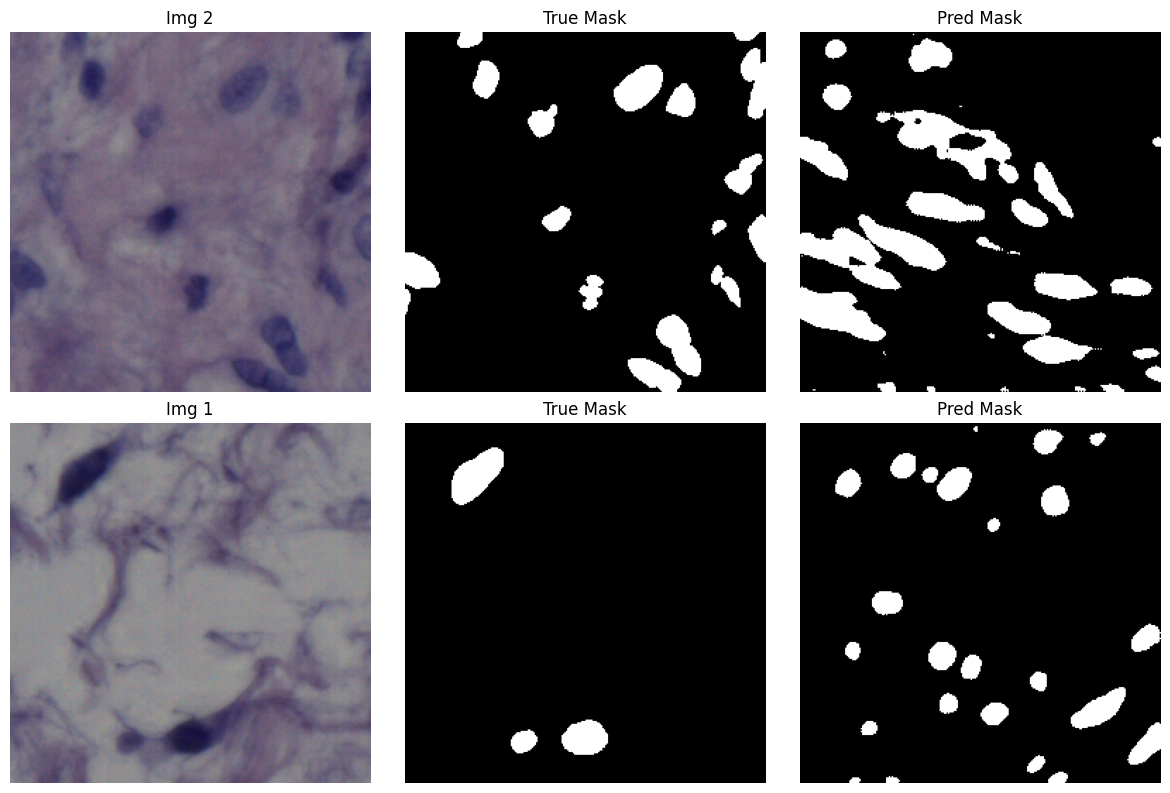

In [ ]:
# Compute per-sample Dice on val set
per_image = []
with torch.no_grad():
    for i in range(len(all_masks)):
        pred = (torch.sigmoid(all_logits[i:i+1]) > 0.5).float()
        true = all_masks[i:i+1]
        per_dice = dice_coeff(pred, true).item()
        per_image.append((i, per_dice))

# Sort and print bottom 5
per_image.sort(key=lambda x: x[1])
print("Worst 5 samples by Dice:")
for idx, d in per_image[:5]:
    print(f" Sample {idx:03d} – Dice: {d:.4f}")

# Visualize a couple
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for row, (idx, _) in enumerate(per_image[:2]):
    img = X_tensor[idx].permute(1,2,0).numpy()
    true = Y_tensor[idx].squeeze().numpy()
    pred = (torch.sigmoid(all_logits[idx:idx+1])[0].squeeze() > 0.5).numpy()

    axes[row,0].imshow(img); axes[row,0].set_title(f"Img {idx}")
    axes[row,1].imshow(true, cmap='gray'); axes[row,1].set_title("True Mask")
    axes[row,2].imshow(pred, cmap='gray'); axes[row,2].set_title("Pred Mask")

for ax in axes.flatten(): 
    ax.axis('off')
plt.tight_layout()
plt.show()


Define post‐processing cleanup function

In [ ]:
import cv2

def clean_mask(mask, min_size=100):
    """
    Remove connected components smaller than `min_size` pixels.
    mask: 2D numpy array (H, W), values 0 or 1
    """
    # Ensure binary uint8
    m = (mask > 0).astype(np.uint8)
    # Connected components
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(m, connectivity=8)
    cleaned = np.zeros_like(m)
    # Skip label 0 (background)
    for lbl in range(1, num_labels):
        area = stats[lbl, cv2.CC_STAT_AREA]
        if area >= min_size:
            cleaned[labels == lbl] = 1
    return cleaned


Apply cleanup in inference & visualize before vs. after

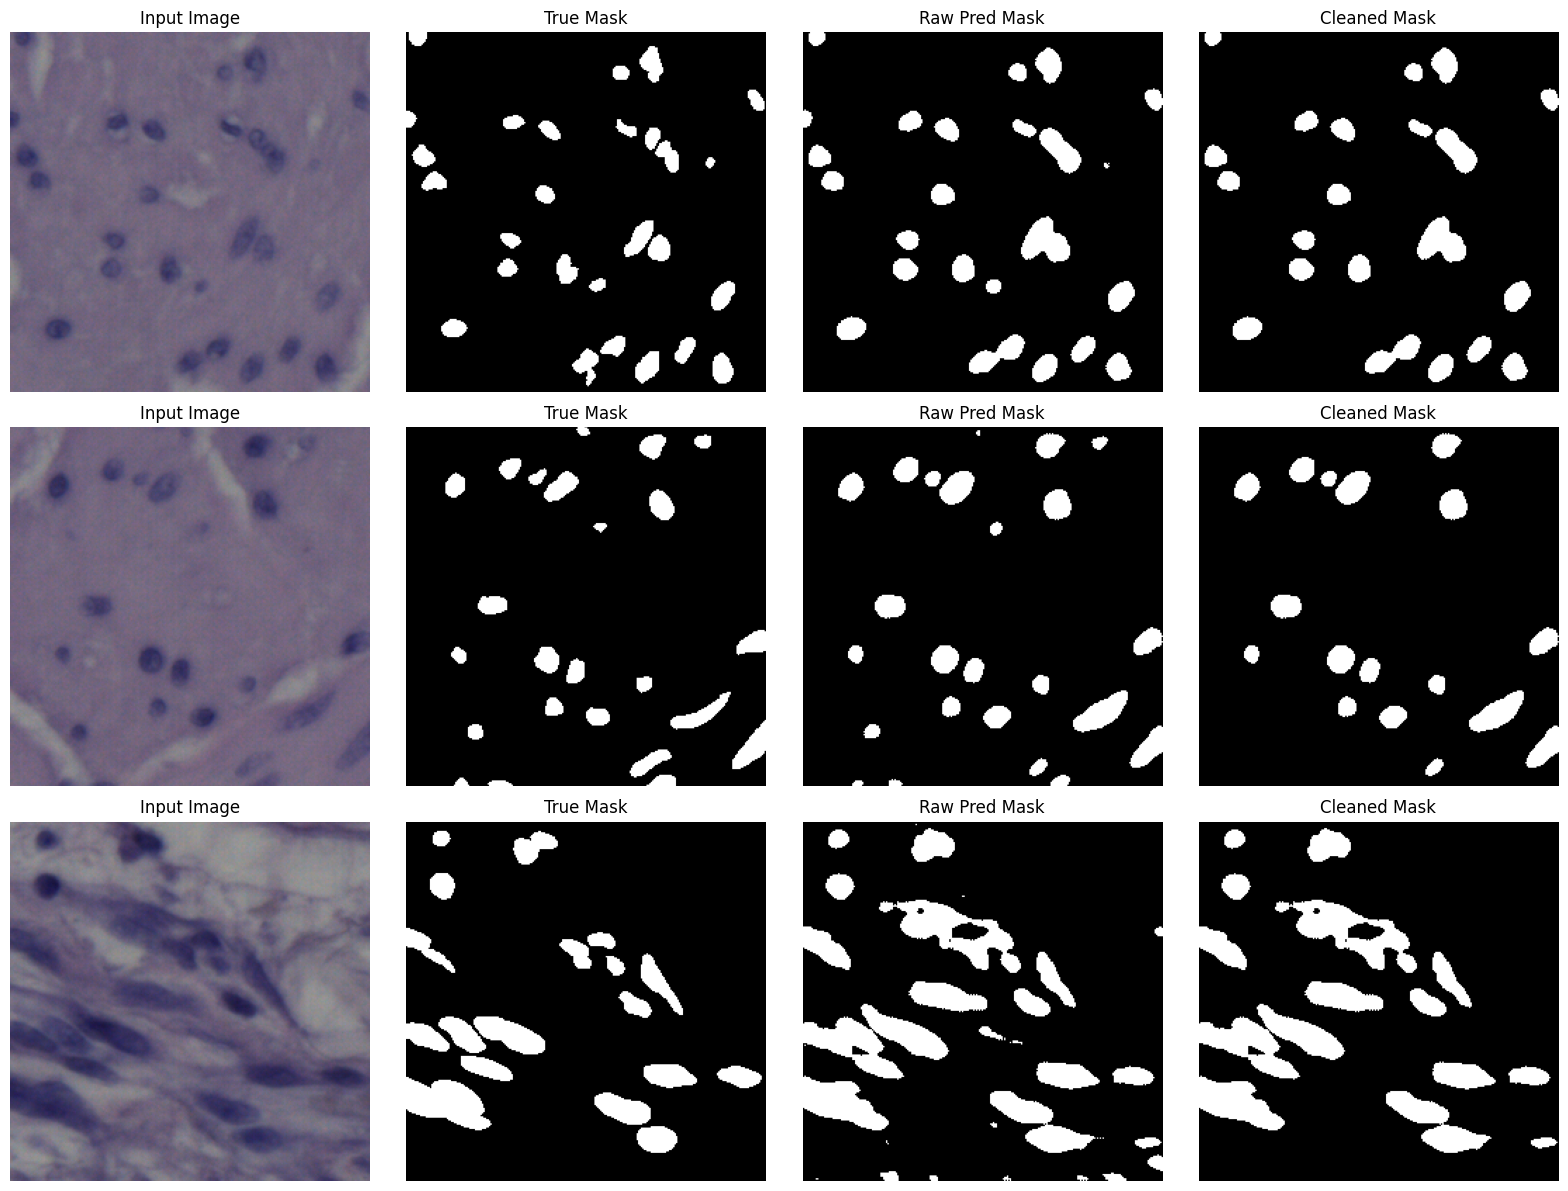

In [ ]:
model.eval()
with torch.no_grad():
    imgs, masks = next(iter(val_loader))
    imgs = imgs.to(device)
    logits = model(imgs)
    probs = torch.sigmoid(logits).cpu().numpy()


num_vis = 3
fig, axes = plt.subplots(num_vis, 4, figsize=(16, num_vis * 4))
for i in range(num_vis):
    img = imgs[i].permute(1,2,0).cpu().numpy()
    true_m = masks[i].squeeze().cpu().numpy()
    raw_pred = (probs[i].squeeze() > 0.5).astype(np.uint8)
    clean_pred = clean_mask(raw_pred, min_size=100)

    axes[i,0].imshow(img);      axes[i,0].set_title('Input Image');   axes[i,0].axis('off')
    axes[i,1].imshow(true_m, cmap='gray'); axes[i,1].set_title('True Mask');     axes[i,1].axis('off')
    axes[i,2].imshow(raw_pred, cmap='gray'); axes[i,2].set_title('Raw Pred Mask'); axes[i,2].axis('off')
    axes[i,3].imshow(clean_pred, cmap='gray'); axes[i,3].set_title('Cleaned Mask');  axes[i,3].axis('off')

plt.tight_layout()
plt.show()


Inspect component‐size distribution to pick a good min_size

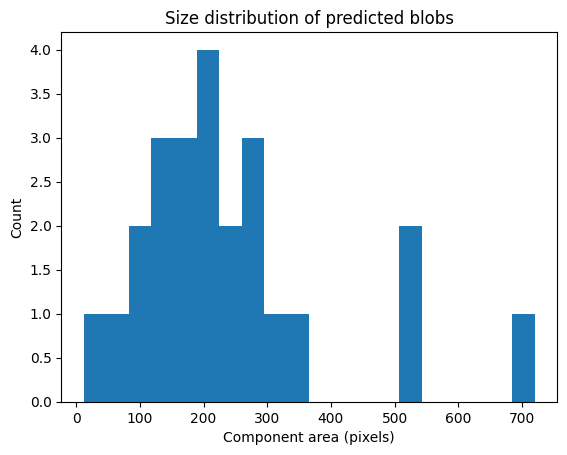

Areas summary (min,10%,25%,50%,75%,90%,max):
12 [ 94.7 147.  209.  270.5 456.6] 720


In [ ]:
# Take one example raw mask (0/1) from your validation set
raw = (probs[0].squeeze() > 0.5).astype(np.uint8)

# Compute connected‐component stats
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(raw, connectivity=8)
areas = stats[1:, cv2.CC_STAT_AREA]  # skip background

# Plot histogram
plt.hist(areas, bins=20)
plt.xlabel("Component area (pixels)")
plt.ylabel("Count")
plt.title("Size distribution of predicted blobs")
plt.show()

# Print some percentiles
print("Areas summary (min,10%,25%,50%,75%,90%,max):")
print(np.min(areas), np.percentile(areas, [10,25,50,75,90]), np.max(areas))


Define a lighter cleanup using morphological opening

In [ ]:
def clean_mask_opening(mask, kernel_size=3):
    """
    Remove very small noise via morphological opening.
    mask: 2D array of 0/1
    kernel_size: size of structuring element
    """
    m = (mask > 0).astype(np.uint8) * 255
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    opened = cv2.morphologyEx(m, cv2.MORPH_OPEN, kernel)
    return (opened > 0).astype(np.uint8)


Compare raw, CC‐cleanup, and opening cleanup

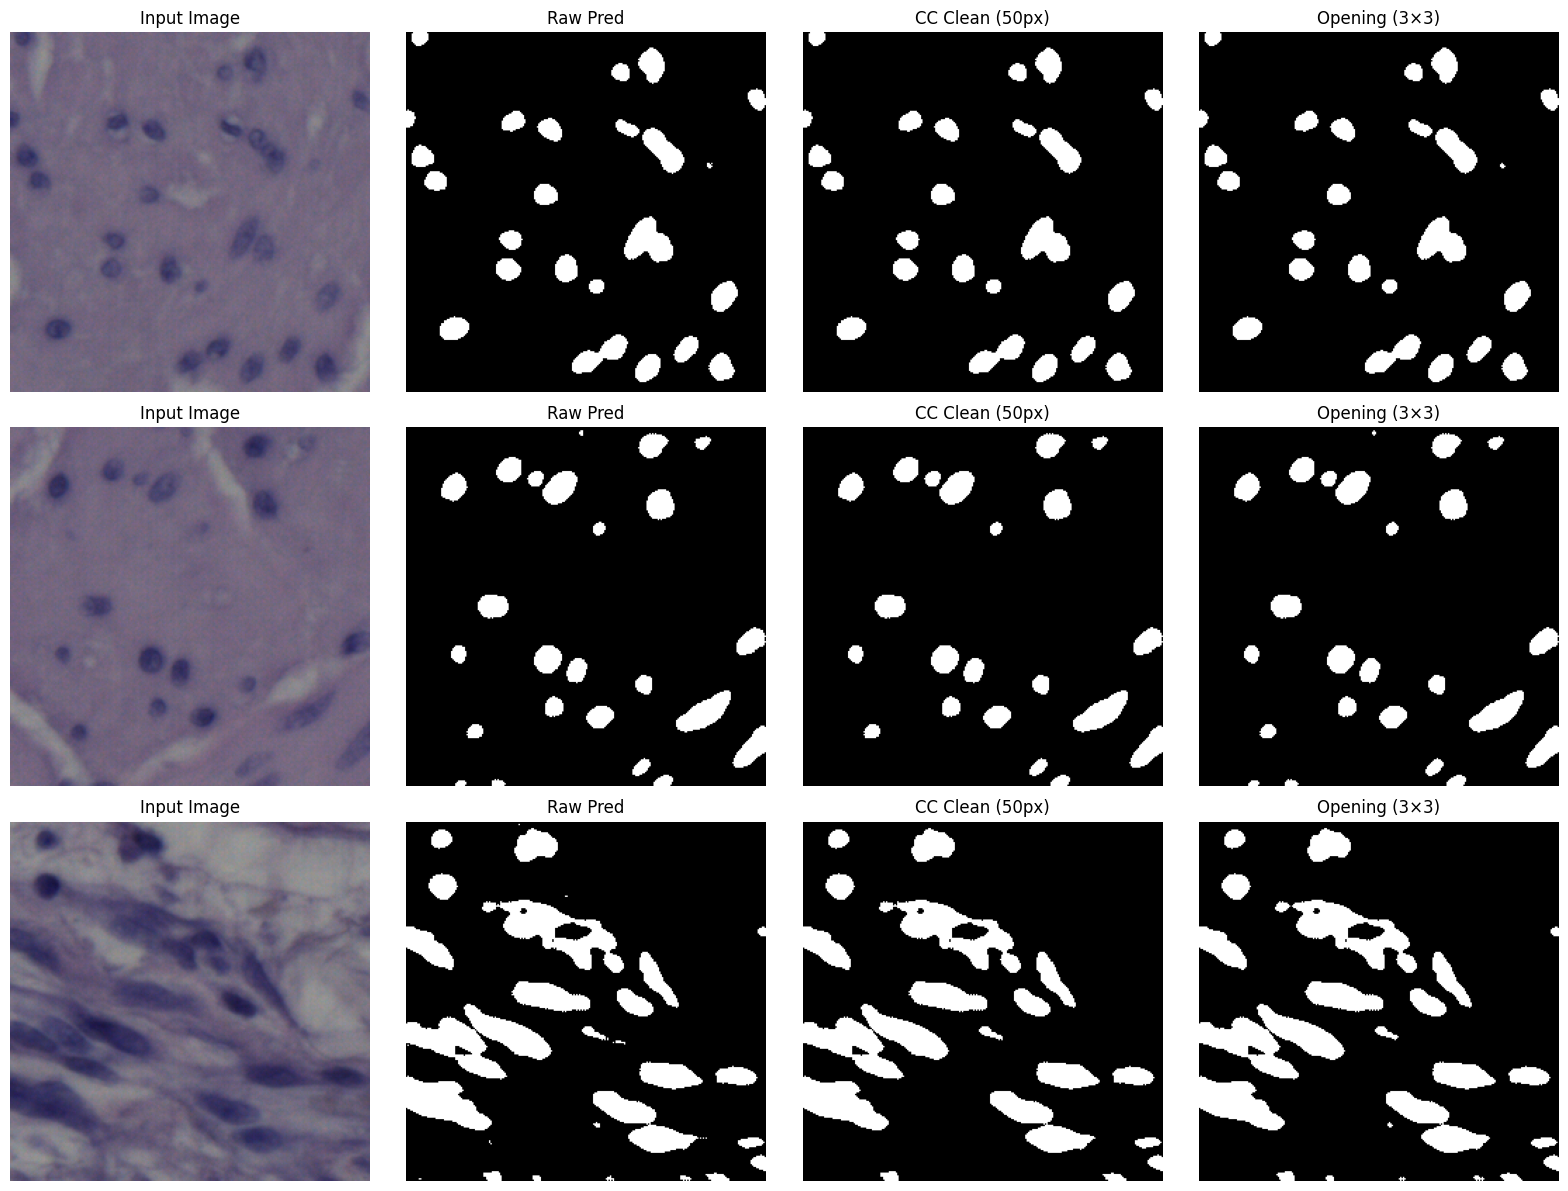

In [ ]:
num_vis = 3
fig, axes = plt.subplots(num_vis, 4, figsize=(16, num_vis*4))
for i in range(num_vis):
    img = imgs[i].permute(1,2,0).cpu().numpy()
    true_m = masks[i].squeeze().cpu().numpy()
    raw_pred = (probs[i].squeeze() > 0.5).astype(np.uint8)
    cc_clean = clean_mask(raw_pred, min_size=50)       # try a smaller threshold
    open_clean = clean_mask_opening(raw_pred, 3)       # opening with 3×3 kernel

    axes[i,0].imshow(img);      axes[i,0].set_title('Input Image');   axes[i,0].axis('off')
    axes[i,1].imshow(raw_pred, cmap='gray'); axes[i,1].set_title('Raw Pred');   axes[i,1].axis('off')
    axes[i,2].imshow(cc_clean, cmap='gray');  axes[i,2].set_title('CC Clean (50px)'); axes[i,2].axis('off')
    axes[i,3].imshow(open_clean, cmap='gray');axes[i,3].set_title('Opening (3×3)'); axes[i,3].axis('off')

plt.tight_layout()
plt.show()
